# Getting Started with recnn
This is my school project. It focuses on Reinforcement Learning for personalized news recommendation. The main distinction is that it tries to solve online off-policy learning with dynamically generated item embeddings. I want to create a library with SOTA algorithms for reinforcement learning recommendation, providing the level of abstraction you like. In this notebook, you can play around with library's key components.

P.S. this tutorial is available online on Google Colab

In [1]:
# == recnn ==
import sys
sys.path.append("../../")
import recnn

import recnn
import torch
import torch.nn as nn
from tqdm.auto import tqdm

tqdm.pandas()

# Environments

Main abstraction of the library for datasets is called environment, similar to how other reinforcement
learning libraries name it. This interface is created to provide SARSA like input for your RL Models. When you are working with recommendation env, you have two choices: using static length inputs (say 10 items) or dynamic length time series with sequential encoders (many to one rnn). Static length is provided via FrameEnv, and dynamic length along with sequential state representation encoder is implemented in SeqEnv. Let’s take a look at FrameEnv first:

In order to initialize an env, you need to provide embeddings and ratings directories.

In [2]:
frame_size = 10
batch_size = 25
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
env = recnn.data.env.FrameEnv('../../data/embeddings/ml20_pca128.pkl',
                         '../../data/ml-20m/ratings.csv', frame_size, batch_size)

You can get train and test batches directly from the environmnent

In [3]:
train = env.train_batch()
test = env.train_batch()
state, action, reward, next_state, done = recnn.data.get_base_batch(train)

In [4]:
print(state)

tensor([[-20.7051,   1.3783,   6.9111,  ...,   3.0000,   5.0000,   5.0000],
        [ -4.7996,  -0.6336,  -5.3247,  ...,   5.0000,   5.0000,   3.0000],
        [  3.3822,  -4.1465, -11.3492,  ...,   5.0000,   3.0000,   3.0000],
        ...,
        [  4.8625,  -3.3130, -10.0822,  ...,   1.0000,   2.0000,   3.0000],
        [  5.0448,  -4.9068,  -8.0425,  ...,   2.0000,   3.0000,   2.0000],
        [  4.4657,  -2.1290,  -2.3245,  ...,   3.0000,   2.0000,   3.0000]])


Let's initialize main networks, and recommend something!

In [5]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

In [6]:
recommendation = policy_net(state)
value = value_net(state, recommendation)
print(recommendation)
print(value)

tensor([[ 2.9603, -4.9067, -0.9599,  ..., -3.8935, -1.9723,  4.9623],
        [ 8.6375,  4.2093,  5.4841,  ..., -6.4383, -4.8687,  2.0493],
        [ 1.9511, -2.6274, -2.7849,  ...,  1.7107, -1.1376,  1.9170],
        ...,
        [ 1.8189,  3.7008, -3.0808,  ..., -1.2926, -2.2316,  4.2574],
        [ 2.0102, -2.6320,  3.7318,  ..., -4.2022,  5.5818,  4.9090],
        [-1.2894, -0.0471, -3.8478,  ..., -1.6197, -5.1634,  5.3723]],
       grad_fn=<AddmmBackward>)
tensor([[-0.7928],
        [ 0.5450],
        [-1.7051],
        ...,
        [ 1.6221],
        [-1.0711],
        [-1.8789]], grad_fn=<AddmmBackward>)


# Update Functions
Hmm, it does not look like our networks understood something. Let's teach them.

In [24]:
# these are target networks that we need for ddpg algorigm to work
target_value_net = recnn.nn.Critic(1290, 128, 256)
target_policy_net = recnn.nn.Actor(1290, 128, 256)

target_policy_net.eval()
target_value_net.eval()


# soft update
recnn.utils.soft_update(value_net, target_value_net, soft_tau=1.0)
recnn.utils.soft_update(policy_net, target_policy_net, soft_tau=1.0)

# define optimizers
value_optimizer = recnn.optim.RAdam(value_net.parameters(),
                              lr=1e-5, weight_decay=1e-2)
policy_optimizer = recnn.optim.RAdam(policy_net.parameters(), lr=1e-5 , weight_decay=1e-2)

nets = {
    'value_net': value_net,
    'target_value_net': target_value_net,
    'policy_net': policy_net,
    'target_policy_net': target_policy_net,
}

optimizer = {
    'policy_optimizer': policy_optimizer,
    'value_optimizer':  value_optimizer
}

debug = {}
writer = recnn.utils.misc.DummyWriter()


In [25]:
step = 0
params = {
    'gamma'      : 0.99,
    'min_value'  : -10,
    'max_value'  : 10,
    'policy_step': 10,
    'soft_tau'   : 0.001,
}
batch = [state, action, reward, next_state]
loss = recnn.nn.update.ddpg_update(batch, params, nets, optimizer,
                       torch.device('cpu'), debug, writer, step=step)
print(loss)

{'value': 18.27610969543457, 'policy': -0.27401024103164673, 'step': 0}


## Training Loop
Let's wrap this thing in the training loop. I also will use Colab's gpu for training.

In an error pops up, go to runtime -> change runtime type -> select GPU. And also restart the session.

In [12]:
cuda = torch.device('cuda')
loss = {
    'test': {'value': [], 'policy': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }

plotter = recnn.utils.Plotter(loss, [['value', 'policy']],)

nets = {
    'value_net': value_net.to(cuda),
    'target_value_net': target_value_net.to(cuda),
    'policy_net': policy_net.to(cuda),
    'target_policy_net': target_policy_net.to(cuda),
}


In [13]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    batch = batch[:4] # no done support for update functions just yet
    loss = recnn.nn.ddpg_update(batch, params, nets, optimizer,
                       cuda, debug, writer, step=step, learn=False)
    return loss

step 14100


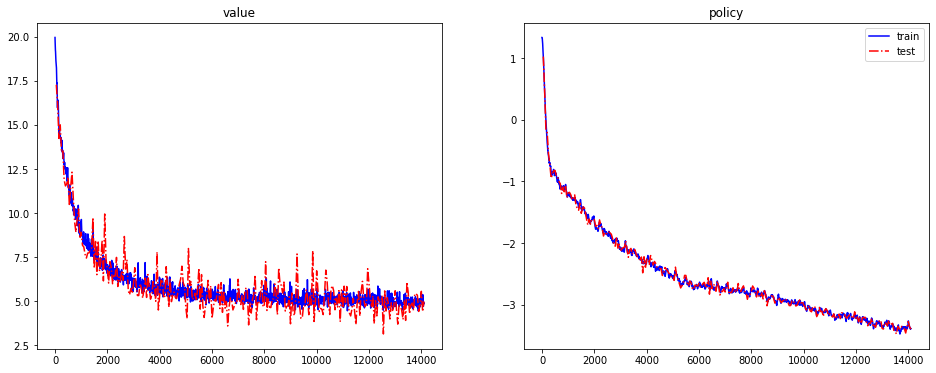

KeyboardInterrupt: 

In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

for epoch in range(n_epochs):
    for batch in tqdm(env.train_dataloader):
        batch = batch[:4] # no done support for update functions just yet
        loss = recnn.nn.ddpg_update(batch, params,
                                           nets, optimizer, cuda, debug,
                                           writer, step=step)
        plotter.log_losses(loss)
        step += 1
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            test_loss = run_tests()
            plotter.log_losses(loss, test=True)
            plotter.plot_loss()

# Algo classes

Algo is a high level abstraction for an RL algorithm. You need two networks (policy and value) in order to initialize it. Later on you can tweak parameters and stuff in the algo itself
.
#### Important: you can set writer to torch.SummaryWriter and get the debug output


## Tweak how you want
```
ddpg = recnn.nn.DDPG(policy_net, value_net)
print(ddpg.params)
ddpg.params['gamma'] = 0.9
ddpg.params['policy_step'] = 3
ddpg.optimizers['policy_optimizer'] = torch.optim.Adam(ddpg.nets['policy_net'], your_lr)
ddpg.writer = torch.utils.tensorboard.SummaryWriter('./runs')
ddpg = ddpg.to(torch.device('cuda'))
```

ddpg.loss_layout is also handy, it allows you to see how the loss should look like

In [12]:
cuda = torch.device('cuda')
ddpg = recnn.nn.DDPG(policy_net, value_net)
ddpg = ddpg.to(cuda)
plotter = recnn.utils.Plotter(ddpg.loss_layout, [['value', 'policy']],)

In [13]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    batch = batch[:4] # no done support for update functions just yet
    loss = ddpg.update(batch, learn=False)
    return loss

step 500


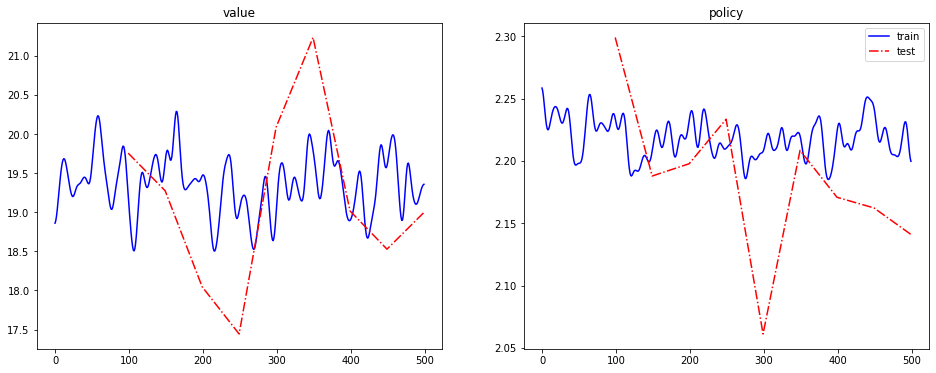

KeyboardInterrupt: 

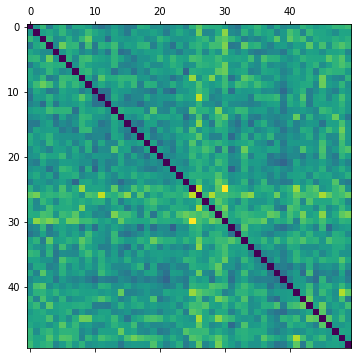

In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

for epoch in range(n_epochs):
    for batch in tqdm(env.train_dataloader):
        batch = batch[:4] # no done support for update functions just yet
        loss = ddpg.update(batch, learn=False)
        plotter.log_losses(loss)
        ddpg.step()
        if ddpg._step % plot_every == 0:
            clear_output(True)
            print('step', ddpg._step)
            test_loss = run_tests()
            plotter.log_losses(loss, test=True)
            plotter.plot_loss()